# PAPERMILL

In [1]:
# model's seeds
SEED = 128
NO_AUGMENTATIONS = False

# additional paramters
model_parameter_name = 'sl'
uns_parameter_percentage = 1.0
GPU_ID = '3'
HIDE_SHAPES = []
HIDE_COLORS = []

In [2]:

assert isinstance(SEED, int), "SEED should be an integer"
assert model_parameter_name is not None, "model_parameter_name should not be None"
assert isinstance(uns_parameter_percentage, float), "uns_parameter_percentage should be a float"
assert 0.0 <= uns_parameter_percentage <= 1.0, "uns_parameter_percentage should be in the range [0.0, 1.0]"
assert GPU_ID is not None, "GPU_ID should not be None"
assert HIDE_SHAPES is not None, "HIDE_SHAPES should not be None"
assert HIDE_COLORS is not None, "HIDE_COLORS should not be None"

print("Papermill seed parameter is: " + str(SEED))
print("Papermill model name is: " + model_parameter_name)
print("Papermill uns_parameter_percentage is: " + str(uns_parameter_percentage))
print("Papermill HIDE_SHAPES is: " + str(HIDE_SHAPES))
print("Papermill HIDE_COLORS is: " + str(HIDE_COLORS))
print("Papermill GPU_ID is: " + GPU_ID)

Papermill seed parameter is: 128
Papermill model name is: sl
Papermill uns_parameter_percentage is: 1.0
Papermill HIDE_SHAPES is: []
Papermill HIDE_COLORS is: []
Papermill GPU_ID is: 3


# IMPORTS

In [3]:
import sys
import os

os.environ['CUDA_VISIBLE_DEVICES'] = GPU_ID
sys.path.append(os.path.abspath(".."))       # for 'protonet_mnist_add_utils' folder
sys.path.append(os.path.abspath("../.."))    # for 'data' folder
sys.path.append(os.path.abspath("../../..")) # for 'models' and 'datasets' folders

print(sys.path)

['/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/notebooks', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python38.zip', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/lib-dynload', '', '/users-1/eleonora/.local/lib/python3.8/site-packages', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation', '/users-1/eleonora/reasoning-shortcuts/IXShort']


In [4]:
import math
import torch
import random
import datetime
import itertools
import numpy as np
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt
import torch.nn.functional as F
import setproctitle, socket, uuid
import torchvision.transforms as T

from tqdm import tqdm
from ultralytics import YOLO
from collections import Counter

from utils import fprint
from utils.checkpoint import save_model, create_load_ckpt
from utils.metrics import evaluate_metrics
from utils.status import progress_bar
from utils.dpl_loss import ADDMNIST_DPL

from torch.nn.modules import Module
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset

from protonet_kand_modules.utility_modules.check_gpu import my_gpu_info
from protonet_kand_modules.arguments import args_sl, args_ltn, args_dpl
from protonet_kand_modules.utility_modules.visualizers import plot_primitives
from protonet_kand_modules.data_modules.proto_data_creation import get_random_classes

from backbones.kand_protonet import PrototypicalLoss

from argparse import Namespace

from models import get_model
from models.mnistdpl import MnistDPL

from datasets import get_dataset
from datasets.utils.base_dataset import BaseDataset

%matplotlib inline

# SETUP

In [5]:
MODEL = model_parameter_name
UNS_PERCENTAGE = uns_parameter_percentage

print("Model is: " + MODEL)
print("Uns percentage is: " + str(UNS_PERCENTAGE))

Model is: sl
Uns percentage is: 1.0


In [6]:
if MODEL == 'sl':       args = args_sl
elif MODEL == 'ltn':    args = args_ltn
else:                   args = args_dpl

args.seed = SEED
print("Seed: " + str(args.seed))

# logging
args.conf_jobnum = str(uuid.uuid4())
args.conf_timestamp = str(datetime.datetime.now())
args.conf_host = socket.gethostname()
args.GPU_ID = GPU_ID
args.hide_shapes = HIDE_SHAPES
args.hide_colors = HIDE_COLORS

# set job name
setproctitle.setproctitle(
    "{}_{}_{}".format(
        args.model,
        args.buffer_size if "buffer_size" in args else 0,
        args.dataset,
    )
)

# saving
save_folder = "kand" 
save_model_name = MODEL
save_path = os.path.join("..",
    "outputs", 
    save_folder, 
    "my_models", 
    save_model_name,
    f"[F]-episodic-proto-net-pipeline-{UNS_PERCENTAGE}-HIDE-SHAPES-{HIDE_SHAPES}-HIDE-COLORS-{HIDE_COLORS}",
)
if NO_AUGMENTATIONS:
    save_path += "-NO-AUGMENTATIONS"
print(f"Save path: {str(save_path)}")

if args.model in ['kandsl', 'kandltn', 'kanddpl'] or not args.prototypes:
    raise ValueError("This experiment is NOT meant for baseline models.")

Seed: 128
Save path: ../outputs/kand/my_models/sl/[F]-episodic-proto-net-pipeline-1.0-HIDE-SHAPES-[]-HIDE-COLORS-[]


In [7]:
my_yolo_project_path = f"ultralytics-{args.GPU_ID}/"
my_yolo_premodel_path = f"ultralytics-{args.GPU_ID}/pretrained/yolo11n.pt"
args.yolo_folder = my_yolo_project_path
my_yolo_project_path


'ultralytics-3/'

In [8]:
my_gpu_info()

Torch version:  1.13.0+cu117
CUDA version:  11.7
Number of GPUs available: 1
Device 0: NVIDIA TITAN Xp
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes


# DATA
*(only one single training image has been annotated; then, through standard data augmentation we derived the 'YOLO training dataset' whose extracted primitives give the 'Protonet Annotated Dataset' + other data augmentations.)*

## YOLO dataset

In [9]:
yaml_path = os.path.join(os.getcwd(), "../data/kand_config_yolo.yaml")
yaml_path

'/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/notebooks/../data/kand_config_yolo.yaml'

## Protonet Annotated Dataset

### Loading the data

In [10]:
proto_images = torch.load('../data/kand_annotations/pnet_proto/concept_prototypes.pt')
proto_labels = torch.load('../data/kand_annotations/pnet_proto/labels_prototypes.pt')
print("Prototypical data loaded")
print("Images: ", proto_images.shape)
print("Labels: ", proto_labels.shape)

Prototypical data loaded
Images:  torch.Size([1467, 3, 64, 64])
Labels:  torch.Size([1467, 2])


In [11]:
if NO_AUGMENTATIONS:
    print("Excluding Augmentations...")
    pairs = {(s, c): (proto_labels[:, 0] == s) & (proto_labels[:, 1] == c)
             for s in range(3) for c in range(3)}
    pair_indices = {k: v.nonzero(as_tuple=True)[0].tolist() for k, v in pairs.items()}
    selected_indices = []
    for s in range(3):
        for c in range(3):
            idxs = pair_indices[(s, c)]
            assert len(idxs) > 0, f"No samples found for pair ({s},{c})"
            chosen = random.choice(idxs)
            selected_indices.append(chosen)

    proto_images = proto_images[selected_indices]
    proto_labels = proto_labels[selected_indices]
    print("Selected indices:", selected_indices)
    print("Sampled labels:\n", proto_labels)
    print(proto_images.shape)
    print(proto_labels.shape)
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i in range(9):
        ax = axes[i // 3, i % 3]
        img_np = proto_images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img_np)
        ax.set_title(f"Shape: {proto_labels[i,0].item()}, Color: {proto_labels[i,1].item()}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

### Creating the Datasets

In [12]:
class PrimitivesDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (Tensor): Tensor of shape [N, 3, 64, 64]
            labels (Tensor): Tensor of shape [N, 2] where:
                             - labels[:, 0] is the shape label  (0: square, 1: circle, 2: triangle)
                             - labels[:, 1] is the colour label (0: red, 1: yellow, 2: blue)
            transform: Optional transformation to apply to images.
        """
        self.images = images
        self.labels = labels  # shape [N, 2]
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        # Return shape label and colour label separately
        shape_label = self.labels[index, 0].long()
        color_label = self.labels[index, 1].long()
        if self.transform:
            image = self.transform(image)
        return image, shape_label.squeeze(), color_label.squeeze()

    def __len__(self):
        return len(self.images)

### Creating the Episodes

In [13]:
from torch.utils.data import Sampler

class FixedBatchSampler(Sampler):
    def __init__(self, dataset_size, batch_size, iterations):
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.iterations = iterations

    def __iter__(self):
        for i in range(self.iterations):
            start = (i * self.batch_size) % self.dataset_size
            end = start + self.batch_size
            if end <= self.dataset_size:
                yield list(range(start, end))
            else:
                # wrap around if needed
                part1 = list(range(start, self.dataset_size))
                part2 = list(range(0, end - self.dataset_size))
                yield part1 + part2

    def __len__(self):
        return self.iterations

In [14]:
class PrototypicalBatchSampler(object):
    """
    Yields a batch of indices for episodic training.
    At each iteration, it randomly selects 'classes_per_it' classes and then picks
    'num_samples' samples for each selected class.
    """
    def __init__(self, labels, classes_per_it, num_samples, iterations):
        """
        Args:
            labels (array-like): 1D array or list of labels for the target task.
                                 This should be either the shape labels or the colour labels.
            classes_per_it (int): Number of random classes for each iteration.
            num_samples (int): Number of samples per class (support + query) in each episode.
            iterations (int): Number of iterations (episodes) per epoch.
        """
        self.labels = np.array(labels)
        self.classes_per_it = classes_per_it
        self.sample_per_class = num_samples
        self.iterations = iterations
        
        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)

        # Create an index matrix of shape (num_classes, max_samples_in_class)
        max_count = max(self.counts)
        self.indexes = np.empty((len(self.classes), max_count), dtype=int)
        self.indexes.fill(-1)
        self.indexes = torch.LongTensor(self.indexes)
        self.numel_per_class = torch.zeros(len(self.classes), dtype=torch.long)

        # Fill in the matrix with indices for each class.
        for idx, label in enumerate(self.labels):
            # Find the row corresponding to this label
            class_idx = (self.classes == label).nonzero(as_tuple=False).item()
            # Find the next available column (where the value is -1)
            pos = (self.indexes[class_idx] == -1).nonzero(as_tuple=False)[0].item()
            self.indexes[class_idx, pos] = idx
            self.numel_per_class[class_idx] += 1

    def __iter__(self):
        """
        Yield a batch of indices for each episode.
        """
        spc = self.sample_per_class
        cpi = self.classes_per_it

        for _ in range(self.iterations):
            batch = torch.LongTensor(cpi * spc)
            # Randomly choose 'classes_per_it' classes
            c_idxs = torch.randperm(len(self.classes))[:cpi]
            for i, class_idx in enumerate(c_idxs):
                s = slice(i * spc, (i + 1) * spc)
                # Randomly choose 'num_samples' indices for the class
                perm = torch.randperm(self.numel_per_class[class_idx])
                sample_idxs = perm[:spc]
                batch[s] = self.indexes[class_idx, sample_idxs]
            # Shuffle the batch indices
            batch = batch[torch.randperm(len(batch))]
            yield batch

    def __len__(self):
        return self.iterations

### Istantiating the DataLoaders

In [15]:
# Create PrimitvesDataset instance
kand_proto_dataset = PrimitivesDataset(proto_images, proto_labels, transform=None)

# Extract the 1D label arrays from the dataset labels. Note: support_dataset.labels is a tensor of shape [N,2].
shape_labels = kand_proto_dataset.labels[:, 0].numpy()  # & ok
color_labels = kand_proto_dataset.labels[:, 1].numpy()  # & ok

# Create episodes sampler for shapes and colours:
shape_sampler = PrototypicalBatchSampler(shape_labels, args.classes_per_it, args.num_samples, args.iterations)
color_sampler = PrototypicalBatchSampler(color_labels, args.classes_per_it, args.num_samples, args.iterations)

# Create dataloaders for each primitve
episodic_shape_dataloader = DataLoader(kand_proto_dataset, batch_sampler=shape_sampler)
episodic_color_dataloader = DataLoader(kand_proto_dataset, batch_sampler=color_sampler)

### Checking the Data

Number of distinct shape labels: 3
Number of distinct color labels: 3
Batch images shape: torch.Size([30, 3, 64, 64])
Batch shape labels: [0, 1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 0, 1, 2, 1, 2, 1, 1, 2, 0, 2, 2, 0, 0, 1, 0, 1, 1, 0]
Shape label distribution in batch: Counter({0: 10, 1: 10, 2: 10})


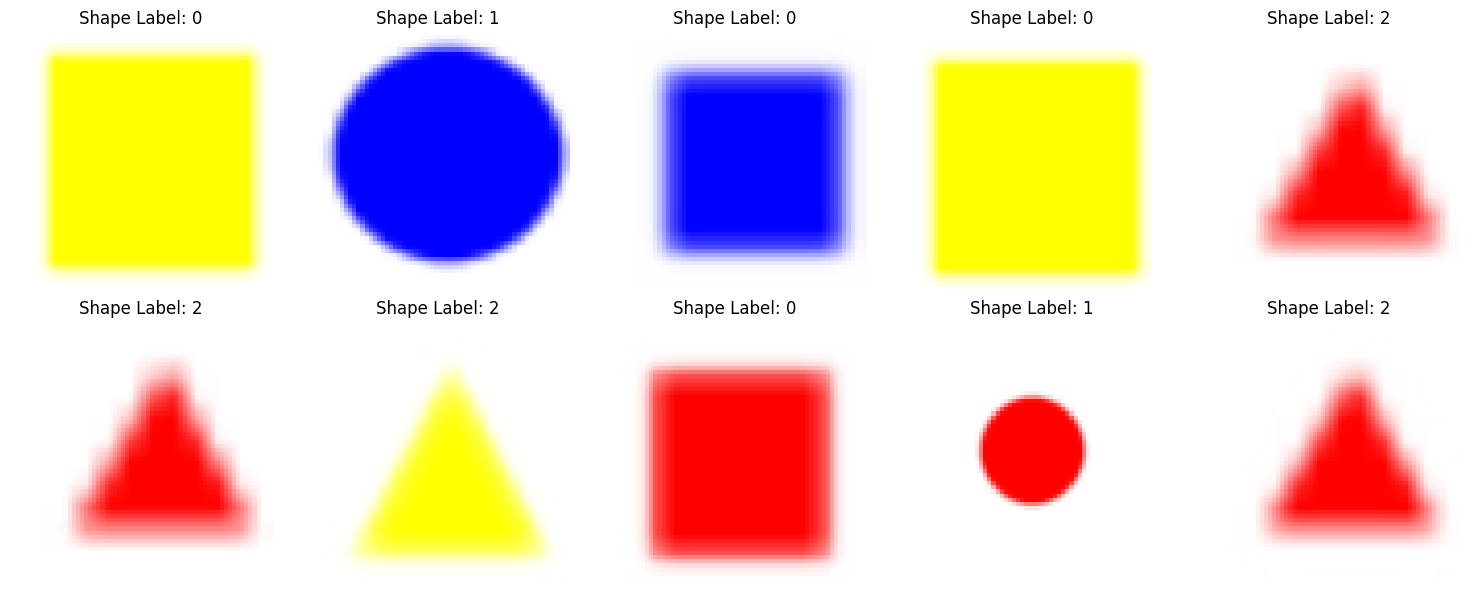


Color-based episodic batch:
Batch images shape: torch.Size([30, 3, 64, 64])
Batch color labels: [0, 1, 2, 2, 0, 1, 1, 1, 0, 0, 0, 2, 1, 2, 2, 0, 1, 0, 1, 0, 2, 0, 1, 2, 1, 1, 2, 2, 2, 0]
Color label distribution in batch: Counter({0: 10, 1: 10, 2: 10})


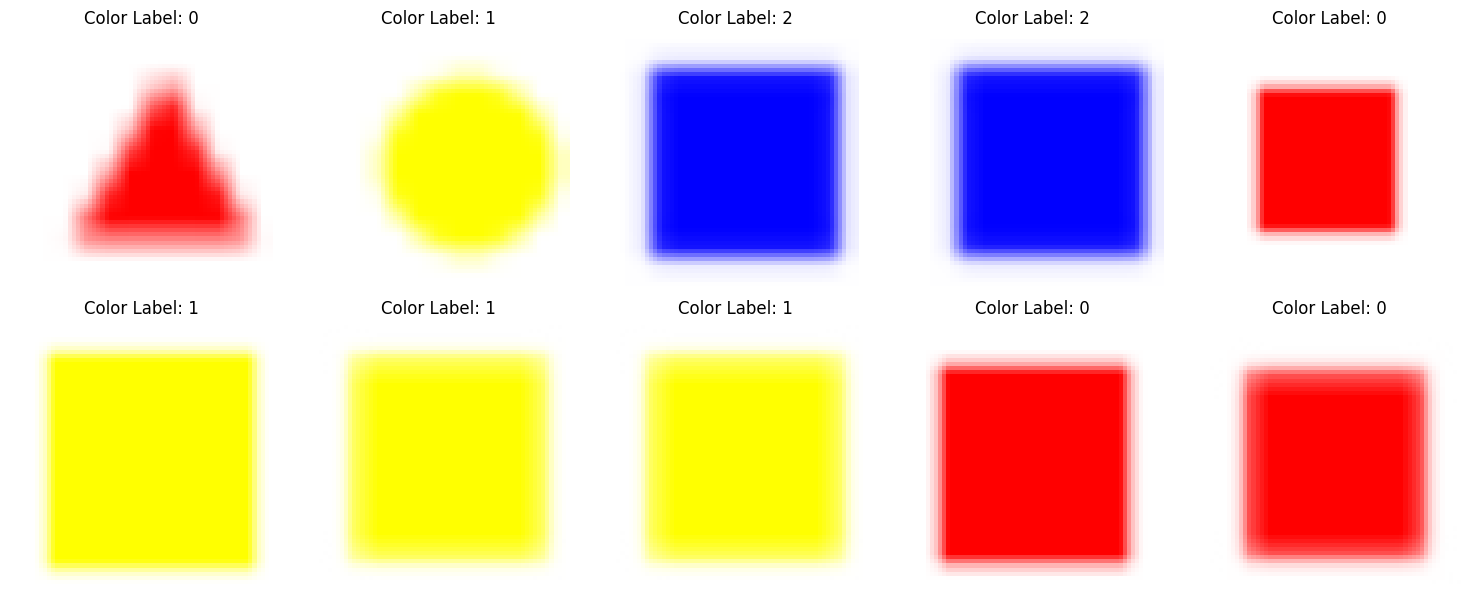

In [16]:
# Extract the 1D label arrays from the dataset labels. Note: support_dataset.labels is a tensor of shape [N,2].
num_distinct_shape_labels = np.unique(shape_labels).size

# Should have 3 labels for shapes (0: square, 1: circle, 2: triangle) and 3 labels for colours (0: red, 1: yellow, 2: blue)
print(f"Number of distinct shape labels: {num_distinct_shape_labels}")
num_distinct_color_labels = np.unique(color_labels).size
print(f"Number of distinct color labels: {num_distinct_color_labels}")

# Prototypical networks expects nunpy arrays for labels
assert isinstance(shape_labels, np.ndarray), "shape labels should be a numpy.ndarray"
assert isinstance(color_labels, np.ndarray), "color labels should be a numpy.ndarray"

# Check tensor shapes and values
assert kand_proto_dataset.images.shape == (shape_labels.size, 3, 64, 64), \
    f"The shape of kand_proto_dataset.images should be (number of shape labels, 3, 64, 64), but got {kand_proto_dataset.images.shape}"
assert kand_proto_dataset.images.shape == (color_labels.size, 3, 64, 64), \
    f"The shape of kand_proto_dataset.images should be (number of color labels, 3, 64, 64), but got {kand_proto_dataset.images.shape}"
assert kand_proto_dataset.labels.shape == (color_labels.size, 2), \
    "The shape of mnist_dataset.labels should be (number of shape labels, 1)"
assert kand_proto_dataset.labels.shape == (color_labels.size, 2), \
    "The shape of mnist_dataset.labels should be (number of color labels, 1)"
assert kand_proto_dataset.images.min() >= 0 and kand_proto_dataset.images.max() <= 1, \
    "The values of kand_proto_dataset.images should be between 0 and 1"
assert np.all(np.isin(shape_labels, [0, 1, 2])), "Shape labels should only contain values 0, 1, or 2"
assert np.all(np.isin(color_labels, [0, 1, 2])), "Color labels should only contain values 0, 1, or 2"    

for batch in episodic_shape_dataloader:
    images, shape_labels_batch, _ = batch
    shape_labels_list = shape_labels_batch.tolist()
    label_counts = Counter(shape_labels_list)
    print("Batch images shape:", images.shape)  # Expected: [batch_size, 3, 64, 64]
    print("Batch shape labels:", shape_labels_list)
    print("Shape label distribution in batch:", label_counts)
    break
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
min_range = min(shape_labels.shape[0], 10)
for i in range(min_range):
    ax = axes[i // 5, i % 5]
    img = images[i].permute(1, 2, 0).numpy() # Convert tensor from (3, 64, 64) to (64, 64, 3) for display
    ax.imshow(img)
    ax.set_title(f"Shape Label: {shape_labels_list[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

### Inspect one batch from the color dataloader
print("\nColor-based episodic batch:")
for batch in episodic_color_dataloader:
    images, _, color_labels_batch = batch
    # We only need the color labels for the color network
    color_labels_list = color_labels_batch.tolist()
    label_counts = Counter(color_labels_list)
    print("Batch images shape:", images.shape)  # Expected: [batch_size, 3, 64, 64]
    print("Batch color labels:", color_labels_list)
    print("Color label distribution in batch:", label_counts)
    break
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
min_range = min(shape_labels.shape[0], 10)
for i in range(min_range):
    ax = axes[i // 5, i % 5]
    img = images[i].permute(1, 2, 0).numpy() # Convert tensor from (3, 64, 64) to (64, 64, 3) for display
    ax.imshow(img)
    ax.set_title(f"Color Label: {color_labels_list[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Unsupervised Dataset

In [17]:
unsup_dataset = get_dataset(args)
print(unsup_dataset)

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']


# MODEL CREATION

In [18]:

# & Instatiate the main model
n_images, c_split = unsup_dataset.get_split()
encoder, decoder = unsup_dataset.get_backbone()
model = get_model(args, encoder, decoder, n_images, c_split)    
loss = model.get_loss(args)

print("Using Dataset: ", unsup_dataset)
print("Number of images: ", n_images)
print("Using backbone: ", encoder)
print("Using Model: ", model)
print("Using Loss: ", loss)
print("Working with taks: ", args.task)

# & Initialize the two distinct prototypical classifiers
print("Shapes encoder: ", model.encoder[0].to(args.device))
print("Colors encoder: ", model.encoder[1].to(args.device))

# & Load the pretrained concept extractor
yolo = YOLO(my_yolo_premodel_path)

kand says Namespace(GPU_ID='3', and_op='Prod', backbone='conceptizer', batch_size=32, beta=0.99, boia_model='ce', boia_ood_knowledge=False, c_sup=0.0, c_sup_ltn=0, checkin=None, checkout=False, classes_per_it=3, concept_extractor_path='ultralytics/finetuned/kand_best_100.pt', conf_host='pssr', conf_jobnum='3d10880f-3b76-4012-a6c6-7bdbcf91907a', conf_timestamp='2025-09-29 14:39:24.492627', count=30, dataset='kandinsky', debug=False, device=device(type='cuda'), embedding_dim=1024, entity='', entropy=False, exp_decay=0.9, extractor_training_epochs=20, gamma=0.001, hide_colors=[], hide_shapes=[], imp_op='Prod', iterations=100, joint=False, lr=0.001, model='prokandsl', n_epochs=40, n_support=75, non_verbose=False, notes=None, num_distinct_labels=3, num_query=5, num_samples=10, num_support=5, or_op='Prod', p=2, patience=5, posthoc=False, preprocess=False, proj_name='', project='Reasoning-Shortcuts', proto_epochs=10, proto_lr=0.001, prototypes=True, prototypical_batch_size=32, prototypical_lo

In [19]:
model.encoder[0].missing_classes = args.hide_shapes
model.encoder[0].num_hidden = len(args.hide_shapes)

model.encoder[1].missing_classes = args.hide_colors
model.encoder[1].num_hidden = len(args.hide_colors)

assert model.encoder[0].missing_classes == args.hide_shapes, "Shape encoder should have hidden classes"
assert model.encoder[1].missing_classes == args.hide_colors, "Color encoder should have hidden classes"

if args.hide_shapes:
    assert model.encoder[0].num_hidden > 0, "Shape encoder should have hidden classes"
    model.encoder[0].unknown_prototypes = nn.Parameter(torch.randn(model.encoder[0].num_hidden, 1024, requires_grad=True))
if args.hide_colors:
    assert model.encoder[1].num_hidden > 0, "Color encoder should have hidden classes"
    model.encoder[1].unknown_prototypes = nn.Parameter(torch.randn(model.encoder[1].num_hidden, 1024, requires_grad=True))

In [20]:
assert len(model.state_dict()) > 0, "Model state dict is empty. Please check the model initialization."

In [21]:
total_params = 0
num_params = 0
for i, enc in enumerate(model.encoder):
    num_params = sum(p.numel() for p in enc.parameters())
    total_params += num_params
    print(f"Encoder {i} number of parameters: {num_params}")

print(f"Total number of parameters: {total_params}")

Encoder 0 number of parameters: 113088
Encoder 1 number of parameters: 113088
Total number of parameters: 226176


# TRAINING

In [22]:
def filter_hidden_classes(images, labels, hide):
    """
    Filters out images and labels corresponding to the classes in the hide list.

    Args:
        images (torch.Tensor): A tensor of shape (batch_size, 3, 64, 64).
        labels (torch.Tensor): A tensor of shape (batch_size) with labels 0, 1, or 2.
        hide (list): A list of integers representing the classes to hide.

    Returns:
        torch.Tensor, torch.Tensor: Filtered images and labels.
    """
    if hide:
        # Create a mask for labels not in the hide list
        mask = ~torch.isin(labels, torch.tensor(hide, device=labels.device))
        
        # Apply the mask to filter images and labels
        filtered_images = images[mask]
        filtered_labels = labels[mask]
        
        return filtered_images, filtered_labels
    else:
        return images, labels

## Main Loop

In [23]:
def train(model, concept_extractor, concept_extractor_training_path, concept_extractor_project_path, transform,                  
        episodic_shape_dataloader, episodic_color_dataloader, unsup_dataset, 
        _loss, args, seed, save_folder, patience=3):
    
    # for full reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = False
    
    best_cacc = 0.0
    epochs_no_improve = 0
    yolo_save_dir = None
    
    model.to(model.device)
    
    # Initialize optimizers and schedulers
    shape_optimizer = torch.optim.Adam(model.encoder[0].parameters())
    color_optimizer = torch.optim.Adam(model.encoder[1].parameters())
    shape_lr_scheduler = torch.optim.lr_scheduler.StepLR(shape_optimizer, step_size=10, gamma=0.5)
    color_lr_scheduler = torch.optim.lr_scheduler.StepLR(color_optimizer, step_size=10, gamma=0.5)
    
    unsup_train_loader, unsup_val_loader, unsup_test_loader = unsup_dataset.get_data_loaders()

    fprint("\n--- Start of Training ---\n")
    for epoch in range(args.proto_epochs + 1):  # first epoch is for determining the baseline accuracy
        print(f"Epoch {epoch+1}/{args.proto_epochs + 1}")

        # ^ PHASE 1: Training the Concept Extractor
        print('----------------------------------')
        print('--- Concept Extractor Training ---')
        if epoch == 0:
            results = concept_extractor.train(data=concept_extractor_training_path, 
                        epochs=args.extractor_training_epochs, 
                        imgsz=64, 
                        project=concept_extractor_project_path)
            yolo_save_dir = os.path.join(results.save_dir, "weights", "last.pt")
        else:
            assert yolo_save_dir is not None
            concept_extractor = YOLO(yolo_save_dir)
            results = concept_extractor.train(data=concept_extractor_training_path, 
                        epochs=args.extractor_training_epochs, 
                        imgsz=64, 
                        project=concept_extractor_project_path)
            yolo_save_dir = os.path.join(results.save_dir, "weights", "last.pt")

        # ^ PHASE 2: Training the Prototypical Networks
        print('----------------------------------')
        print('--- Prototypical Networks Training ---')
        
        model.train()

        epoch_train_loss_shapes, epoch_train_acc_shapes, epoch_train_loss_colors, epoch_train_acc_colors = [], [], [], []
        
        # * Under the assumption that both dataloaders yield the same number of episodes per epoch.
        pNet_loss = PrototypicalLoss(n_support=args.num_support)
        for (shape_batch, color_batch) in tqdm(zip(episodic_shape_dataloader, episodic_color_dataloader), total=args.iterations):
            
            # ------------------
            # & Process shape episode
            # ------------------
            shape_optimizer.zero_grad()
            shape_images, shape_labels, _ = shape_batch
            shape_images, shape_labels = filter_hidden_classes(shape_images, shape_labels, args.hide_shapes)
            if args.hide_shapes:   assert not any(label in args.hide_shapes for label in shape_labels), "shape_labels contains hidden classes"
            shape_images, shape_labels = shape_images.to(args.device), shape_labels.to(args.device)            

            # Forward pass: compute embeddings for all images in the episode.
            shape_embeddings = model.encoder[0](shape_images)

            # Compute prototypical loss.
            shape_loss, shape_acc = pNet_loss(input=shape_embeddings, target=shape_labels)
            shape_loss.backward()
            shape_optimizer.step()

            epoch_train_loss_shapes.append(shape_loss.item())
            epoch_train_acc_shapes.append(shape_acc.item())

            # ------------------
            # & Process color episode
            # ------------------
            color_optimizer.zero_grad()
            color_images, _, color_labels = color_batch
            color_images, color_labels = filter_hidden_classes(color_images, color_labels, args.hide_colors)
            if args.hide_colors:   assert not any(label in args.hide_colors for label in color_labels), "color_labels contains hidden classes"
            color_images, color_labels = color_images.to(args.device), color_labels.to(args.device)
            
            # Forward pass: compute embeddings for all images in the episode.
            color_embeddings = model.encoder[1](color_images)

            # Compute prototypical loss.
            color_loss, color_acc = pNet_loss(input=color_embeddings, target=color_labels)
            color_loss.backward()
            color_optimizer.step()

            epoch_train_loss_colors.append(color_loss.item())
            epoch_train_acc_colors.append(color_acc.item())

        avg_loss_shapes = np.mean(epoch_train_loss_shapes)
        avg_acc_shapes = np.mean(epoch_train_acc_shapes)
        avg_loss_colors = np.mean(epoch_train_loss_colors)
        avg_acc_colors = np.mean(epoch_train_acc_colors)
        
        print(f"Shapes  - Avg Loss: {avg_loss_shapes:.4f} | Avg Acc: {avg_acc_shapes:.4f}")
        print(f"Colors  - Avg Loss: {avg_loss_colors:.4f} | Avg Acc: {avg_acc_colors:.4f}")

        # ^ PHASE 3: Training the model with Unsupervised Data
        print('----------------------------------')
        print("--- Training with Unsupervised Data ---")

        # ys are the predictions of the model, y_true are the true labels, cs are the predictions of the concepts, cs_true are the true concepts
        ys, y_true, cs, cs_true = None, None, None, None

        unknown_init = True if (len(args.hide_shapes) > 0 or len(args.hide_colors)) else False
        for i,data in enumerate(unsup_train_loader):
            if random.random() > UNS_PERCENTAGE:
                continue  # Skip this batch with probability (1 - percentage)

            if epoch == 0:
                model.eval()
                if args.debug:  print("Find baseline accuracy, no training.")
                assert not model.training, "Model should **NOT** be in training mode!"
                assert not model.encoder[0].training, "Shape encoder should **NOT** be in training mode!"
                assert not model.encoder[1].training, "Color encoder should **NOT** be in training mode!"
            else:    
                shape_optimizer.zero_grad()
                color_optimizer.zero_grad()
                if args.debug:  print("Reset the optimizers.")
                assert model.training, "Model should be in training mode!"
                assert model.encoder[0].training, "Shape encoder should be in training mode!"
                assert model.encoder[1].training, "Color encoder should be in training mode!"

            # load batch
            images, labels, concepts = data
            images, labels, concepts = (
                images.to(model.device),
                labels.to(model.device),
                concepts.to(model.device),
            )
            batch_size = images.shape[0]
            assert images.shape == (batch_size, 3, 64, 192), f"Expected shape (B, 3, 64, 192), but got {images.shape}"
            assert labels.shape == (batch_size, 4), f"Expected shape (B, 4), but got {labels.shape}"
            assert concepts.shape == (batch_size, 3, 6), f"Expected shape (B, 3, 6), but got {concepts.shape}"
            
            # Get a random support set.
            if NO_AUGMENTATIONS:
                this_support_images = kand_proto_dataset.images
                this_support_labels = kand_proto_dataset.labels
            else:
                # Get a random support set.
                this_support_images, this_support_labels = get_random_classes(
                    kand_proto_dataset.images, kand_proto_dataset.labels, args.n_support, args.num_distinct_labels)
                assert this_support_images.shape == (args.n_support * args.num_distinct_labels, 3, 64, 64), \
                    f"Support images shape is not ({args.n_support * args.num_distinct_labels}, 3, 64, 64), but {this_support_images.shape}"
                assert this_support_labels.shape == (args.n_support * args.num_distinct_labels, 2), \
                    f"Support labels shape is not ({args.n_support * args.num_distinct_labels}, 2), but {this_support_labels.shape}"
                
            if args.debug:
                plot_primitives(this_support_images, this_support_labels)

            out_dict = model(images, concept_extractor, transform, this_support_images, this_support_labels, args, unknown_init=unknown_init)
            out_dict.update({"LABELS": labels, "CONCEPTS": concepts})
            unknown_init = False

            loss, losses = _loss(out_dict, args)
            loss.backward()
            
            if epoch != 0:
                if args.debug:  print("Update the schedulers.")
                shape_optimizer.step()
                color_optimizer.step()  

            if ys is None:
                ys = out_dict["YS"]
                y_true = out_dict["LABELS"]
                cs = out_dict["pCS"]
                cs_true = out_dict["CONCEPTS"]
            else:
                ys = torch.concatenate((ys, out_dict["YS"]), dim=0)
                y_true = torch.concatenate((y_true, out_dict["LABELS"]), dim=0)
                cs = torch.concatenate((cs, out_dict["pCS"]), dim=0)
                cs_true = torch.concatenate((cs_true, out_dict["CONCEPTS"]), dim=0)

            if i % 10 == 0:
                progress_bar(i, len(unsup_train_loader) - 9, epoch, loss.item())

        # Step the scheduler (if using)
        if epoch != 0:
            shape_lr_scheduler.step()
            color_lr_scheduler.step()

        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print("End of epoch ", epoch)
        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print()

        # ^ PHASE 4: Evaluation
        print('----------------------------------')
        print('--- Evaluation ---')

        if ys is None:
            # Skip evaluation if no unsupervised data was used for the model  
            torch.save(model.state_dict(), save_folder)
            concept_save_path = os.path.join(os.path.dirname(save_folder), f"best_{seed}.pt")
            concept_extractor.save(concept_save_path)
            print(f"Saved model after prototypical netwrork training.")
            print()
            continue

        if "patterns" in args.task:
            y_true = y_true[:, -1]  # it is the last one

        # Get a random support set.
        if NO_AUGMENTATIONS:
            this_support_images = kand_proto_dataset.images
            this_support_labels = kand_proto_dataset.labels
        else:
            # Get a random support set.
            this_support_images, this_support_labels = get_random_classes(
                kand_proto_dataset.images, kand_proto_dataset.labels, args.n_support, args.num_distinct_labels)
            assert this_support_images.shape == (args.n_support * args.num_distinct_labels, 3, 64, 64), \
                f"Support images shape is not ({args.n_support * args.num_distinct_labels}, 3, 64, 64), but {this_support_images.shape}"
            assert this_support_labels.shape == (args.n_support * args.num_distinct_labels, 2), \
                f"Support labels shape is not ({args.n_support * args.num_distinct_labels}, 2), but {this_support_labels.shape}"
            
        model.eval()
        tloss, cacc, yacc, f1 = evaluate_metrics(model, unsup_val_loader, args, 
                                support_images=this_support_images, support_labels=this_support_labels,
                                concept_extractor=concept_extractor, transform=transform)
        ### LOGGING ###
        fprint("  ACC C", cacc, "  ACC Y", yacc, "F1 Y", f1)
        print()
        
        if not args.tuning and cacc > best_cacc:
            print("Saving...")
            # Update best F1 score
            if best_cacc == 0.0 and args.debug:     print("Baseline accuracy has been determined.")
            best_cacc = cacc
            epochs_no_improve = 0
                
            # Save the best model and the concept extractor
            torch.save(model.state_dict(), save_folder)
            concept_save_path = os.path.join(os.path.dirname(save_folder), f"best_{seed}.pt")
            concept_extractor.save(concept_save_path)
            print(f"Saved best model with CACC score: {best_cacc}")
            print()
        
        elif cacc <= best_cacc:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
    
    fprint("\n--- End of Training ---\n")
    return best_cacc

## Run

In [24]:
print(f"*** Training model with seed {args.seed}")
print("Chosen device:", model.device)
print("Save path for this model: ", save_path)
if not os.path.exists(save_path): os.makedirs(save_path, exist_ok=True)
save_folder = os.path.join(save_path, f"{save_model_name}_{args.seed}.pth")
print("Saving in folder: ", save_folder)
best_cacc = train(model=model,                           # main model
    concept_extractor=yolo,                              # yolo model
    concept_extractor_training_path=yaml_path,           # yolo training data path
    concept_extractor_project_path=my_yolo_project_path, # yolo project path
    transform=T.Resize((64, 64)),                        # resizer 
    episodic_shape_dataloader=episodic_shape_dataloader, # episodic dataloader for shapes
    episodic_color_dataloader=episodic_color_dataloader, # episodic dataloader for colors
    unsup_dataset=unsup_dataset,                         # original weakly supervised dataset
    _loss=loss, 
    args=args,
    seed=args.seed,
    save_folder=save_folder
)
save_model(model, args, args.seed)  # save the model parameters

print(f"Best F1 score: {best_cacc}")

*** Training model with seed 128
Chosen device: cuda
Save path for this model:  ../outputs/kand/my_models/sl/[F]-episodic-proto-net-pipeline-1.0-HIDE-SHAPES-[]-HIDE-COLORS-[]
Saving in folder:  ../outputs/kand/my_models/sl/[F]-episodic-proto-net-pipeline-1.0-HIDE-SHAPES-[]-HIDE-COLORS-[]/sl_128.pth
Loaded datasets in 4.4737207889556885 s.
Len loaders: 
 train: 4000 
 val: 1000
 len test: 1000

--- Start of Training ---

Epoch 1/11
----------------------------------
--- Concept Extractor Training ---
New https://pypi.org/project/ultralytics/8.3.203 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.130 🚀 Python-3.8.20 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False,

train: Scanning /users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/data/kand_yolo_dataset/train/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 14.2±5.2 MB/s, size: 0.5 KB)


val: Scanning /users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/data/kand_yolo_dataset/val/labels.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]


Plotting labels to ultralytics-3/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 64 train, 64 val
Using 8 dataloader workers
Logging results to ultralytics-3/train14
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.109G      1.811      3.509      1.158         92         64: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]

                   all         12         36       0.02      0.111     0.0118    0.00837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.109G      1.336      3.228      1.023         86         64: 100%|██████████| 13/13 [00:02<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]

                   all         12         36     0.0357      0.222     0.0407     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.109G      1.385      2.868      0.986         73         64: 100%|██████████| 13/13 [00:02<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]

                   all         12         36      0.114          1      0.141     0.0701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.109G      1.365      2.326     0.9567         71         64: 100%|██████████| 13/13 [00:02<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]

                   all         12         36     0.0572          1      0.361      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.109G      1.329      1.794     0.9455         63         64: 100%|██████████| 13/13 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]

                   all         12         36      0.804      0.228      0.617      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.109G      1.287      1.399     0.9322         74         64: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]

                   all         12         36      0.956      0.601      0.961      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.109G      1.289      1.137     0.9221         80         64: 100%|██████████| 13/13 [00:02<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]

                   all         12         36      0.899      0.987       0.95      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.109G      1.237     0.9553     0.9226         76         64: 100%|██████████| 13/13 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]

                   all         12         36          1      0.994      0.995      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.109G      1.234     0.8487     0.9128         70         64: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]

                   all         12         36       0.97          1      0.985      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.109G      1.124     0.7878     0.9081         77         64: 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]

                   all         12         36      0.894          1      0.934      0.668


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.109G     0.8714     0.6818     0.8772         42         64: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]

                   all         12         36      0.998          1      0.995      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.109G     0.7456     0.6099     0.8804         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]

                   all         12         36      0.999          1      0.995      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.109G     0.6925      0.578     0.8797         42         64: 100%|██████████| 13/13 [00:02<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]

                   all         12         36      0.999          1      0.995       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.109G     0.6902     0.5765     0.8803         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]

                   all         12         36      0.998          1      0.995      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.109G     0.7179     0.5753     0.8663         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]

                   all         12         36      0.998          1      0.995      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.109G     0.5831     0.5563     0.8729         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

                   all         12         36      0.998          1      0.995      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.109G     0.5919     0.5007     0.8577         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]

                   all         12         36      0.998          1      0.995      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.109G     0.5457     0.5091      0.867         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]

                   all         12         36      0.998          1      0.995      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.109G     0.5049     0.5086     0.8729         42         64: 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]

                   all         12         36      0.998          1      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.109G     0.5169     0.5044     0.8681         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]

                   all         12         36      0.998          1      0.995      0.794



20 epochs completed in 0.016 hours.
Optimizer stripped from ultralytics-3/train14/weights/last.pt, 5.4MB
Optimizer stripped from ultralytics-3/train14/weights/best.pt, 5.4MB

Validating ultralytics-3/train14/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.8.20 torch-1.13.0+cu117 CUDA:3 (NVIDIA TITAN Xp, 12190MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.45it/s]


                   all         12         36      0.998          1      0.995      0.821
Speed: 0.0ms preprocess, 1.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to ultralytics-3/train14
----------------------------------
--- Prototypical Networks Training ---


100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Shapes  - Avg Loss: 3.9477 | Avg Acc: 0.8867
Colors  - Avg Loss: 1.3423 | Avg Acc: 0.9893
----------------------------------
--- Training with Unsupervised Data ---


[ 09-29 | 14:44 ] epoch 0: |██████████████████████████████████████████████████| loss: 40.73071289

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

----------------------------------
--- Evaluation ---
  ACC C 90.89626736111114   ACC Y 77.05078125 F1 Y 75.47387327660314

Saving...
Saved best model with CACC score: 90.89626736111114

Epoch 2/11
----------------------------------
--- Concept Extractor Training ---
New https://pypi.org/project/ultralytics/8.3.203 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.130 🚀 Python-3.8.20 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/note

train: Scanning /users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/data/kand_yolo_dataset/train/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.9±5.1 MB/s, size: 0.5 KB)


val: Scanning /users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/data/kand_yolo_dataset/val/labels.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]


Plotting labels to ultralytics-3/train15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 64 train, 64 val
Using 8 dataloader workers
Logging results to ultralytics-3/train15
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.46G     0.9216     0.6405     0.9117         78         64:  46%|████▌     | 6/13 [00:03<00:03,  1.99it/s]


KeyboardInterrupt: 